In [31]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
# import torch.nn as nn
from utils import calc_energy

# from importlib import reload

In [2]:
vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X, Y = np.meshgrid(xc,yc)
DX, DY = np.meshgrid(dx,dy)
AREA = DX*DY
print(DX.shape)

(181, 181)


In [33]:
in_filename = f'../npz_data/new_cross_data_Re0.01_Wi5_beta0.11111.npz'
# in_filename = f'../npz_data/cross_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz'
# in_filename = f'../npz_data/4_roll6_Re{Re:g}_Wi{Wi:g}_beta{beta:g}_dataset.npz'

eps_u = 1

fields = np.load(in_filename, allow_pickle=True)["fields"].item()
u = fields["vel-u"] * eps_u
v = fields["vel-v"] * eps_u
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]
q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)

q[:65,:65] = np.nan
q[:65,-65:] = np.nan
q[-65:,:65] = np.nan
q[-65:,-65:] = np.nan

In [36]:
tra = q[...,2] + q[...,4]

In [ ]:
(tra[...,50]*AREA)[0,0], tra[...,50][0,0], q[...,50,2][0,0]

(10.01, 10.9903895, 10.01, 10.9903895)

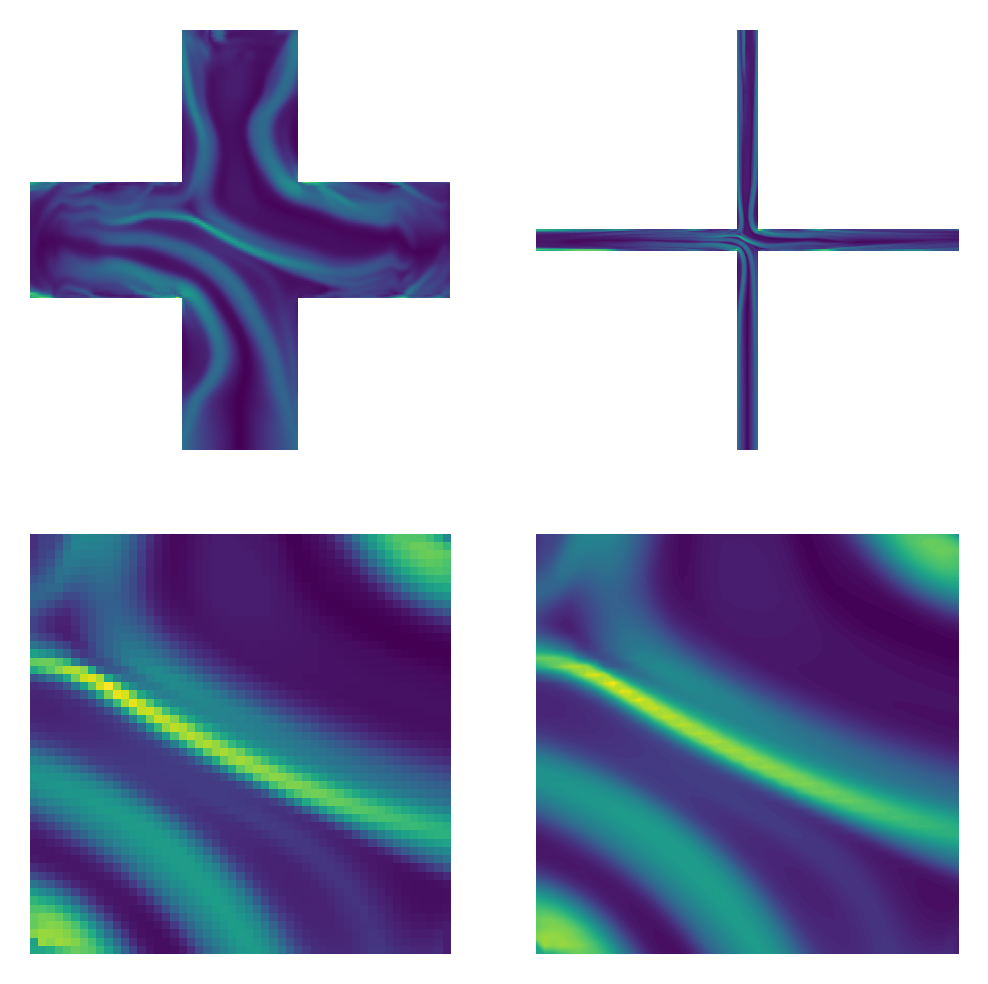

In [37]:
t = 100 
lvs = 100
fig =plt.figure(figsize=(4,4),dpi=300,facecolor='w')
ax1 = plt.subplot(221)
ax1.imshow(tra[...,t], origin='lower')
ax1.axis('off')
ax1 = plt.subplot(222)
ax1.contourf(X,Y, tra[...,t], levels = lvs)
ax1.axis('off')
ax1 = plt.subplot(223)
ax1.imshow(tra[...,t][65:-65,65:-65], origin='lower')
ax1.axis('off')
ax1 = plt.subplot(224)
ax1.contourf(X[65:-65,65:-65],Y[65:-65,65:-65], tra[...,t][65:-65,65:-65], levels = lvs)
ax1.axis('off')

In [ ]:
np.nanmin((tra[...,t])),np.nanmax((tra[...,t]))

In [ ]:
np.nanargmax(tra[...,t]/AREA),(tra[...,t]/AREA).item(67*181+50)

In [ ]:
X[range(181),vmax].shape

In [40]:
4 * 65*51+51**2

181*181

32761

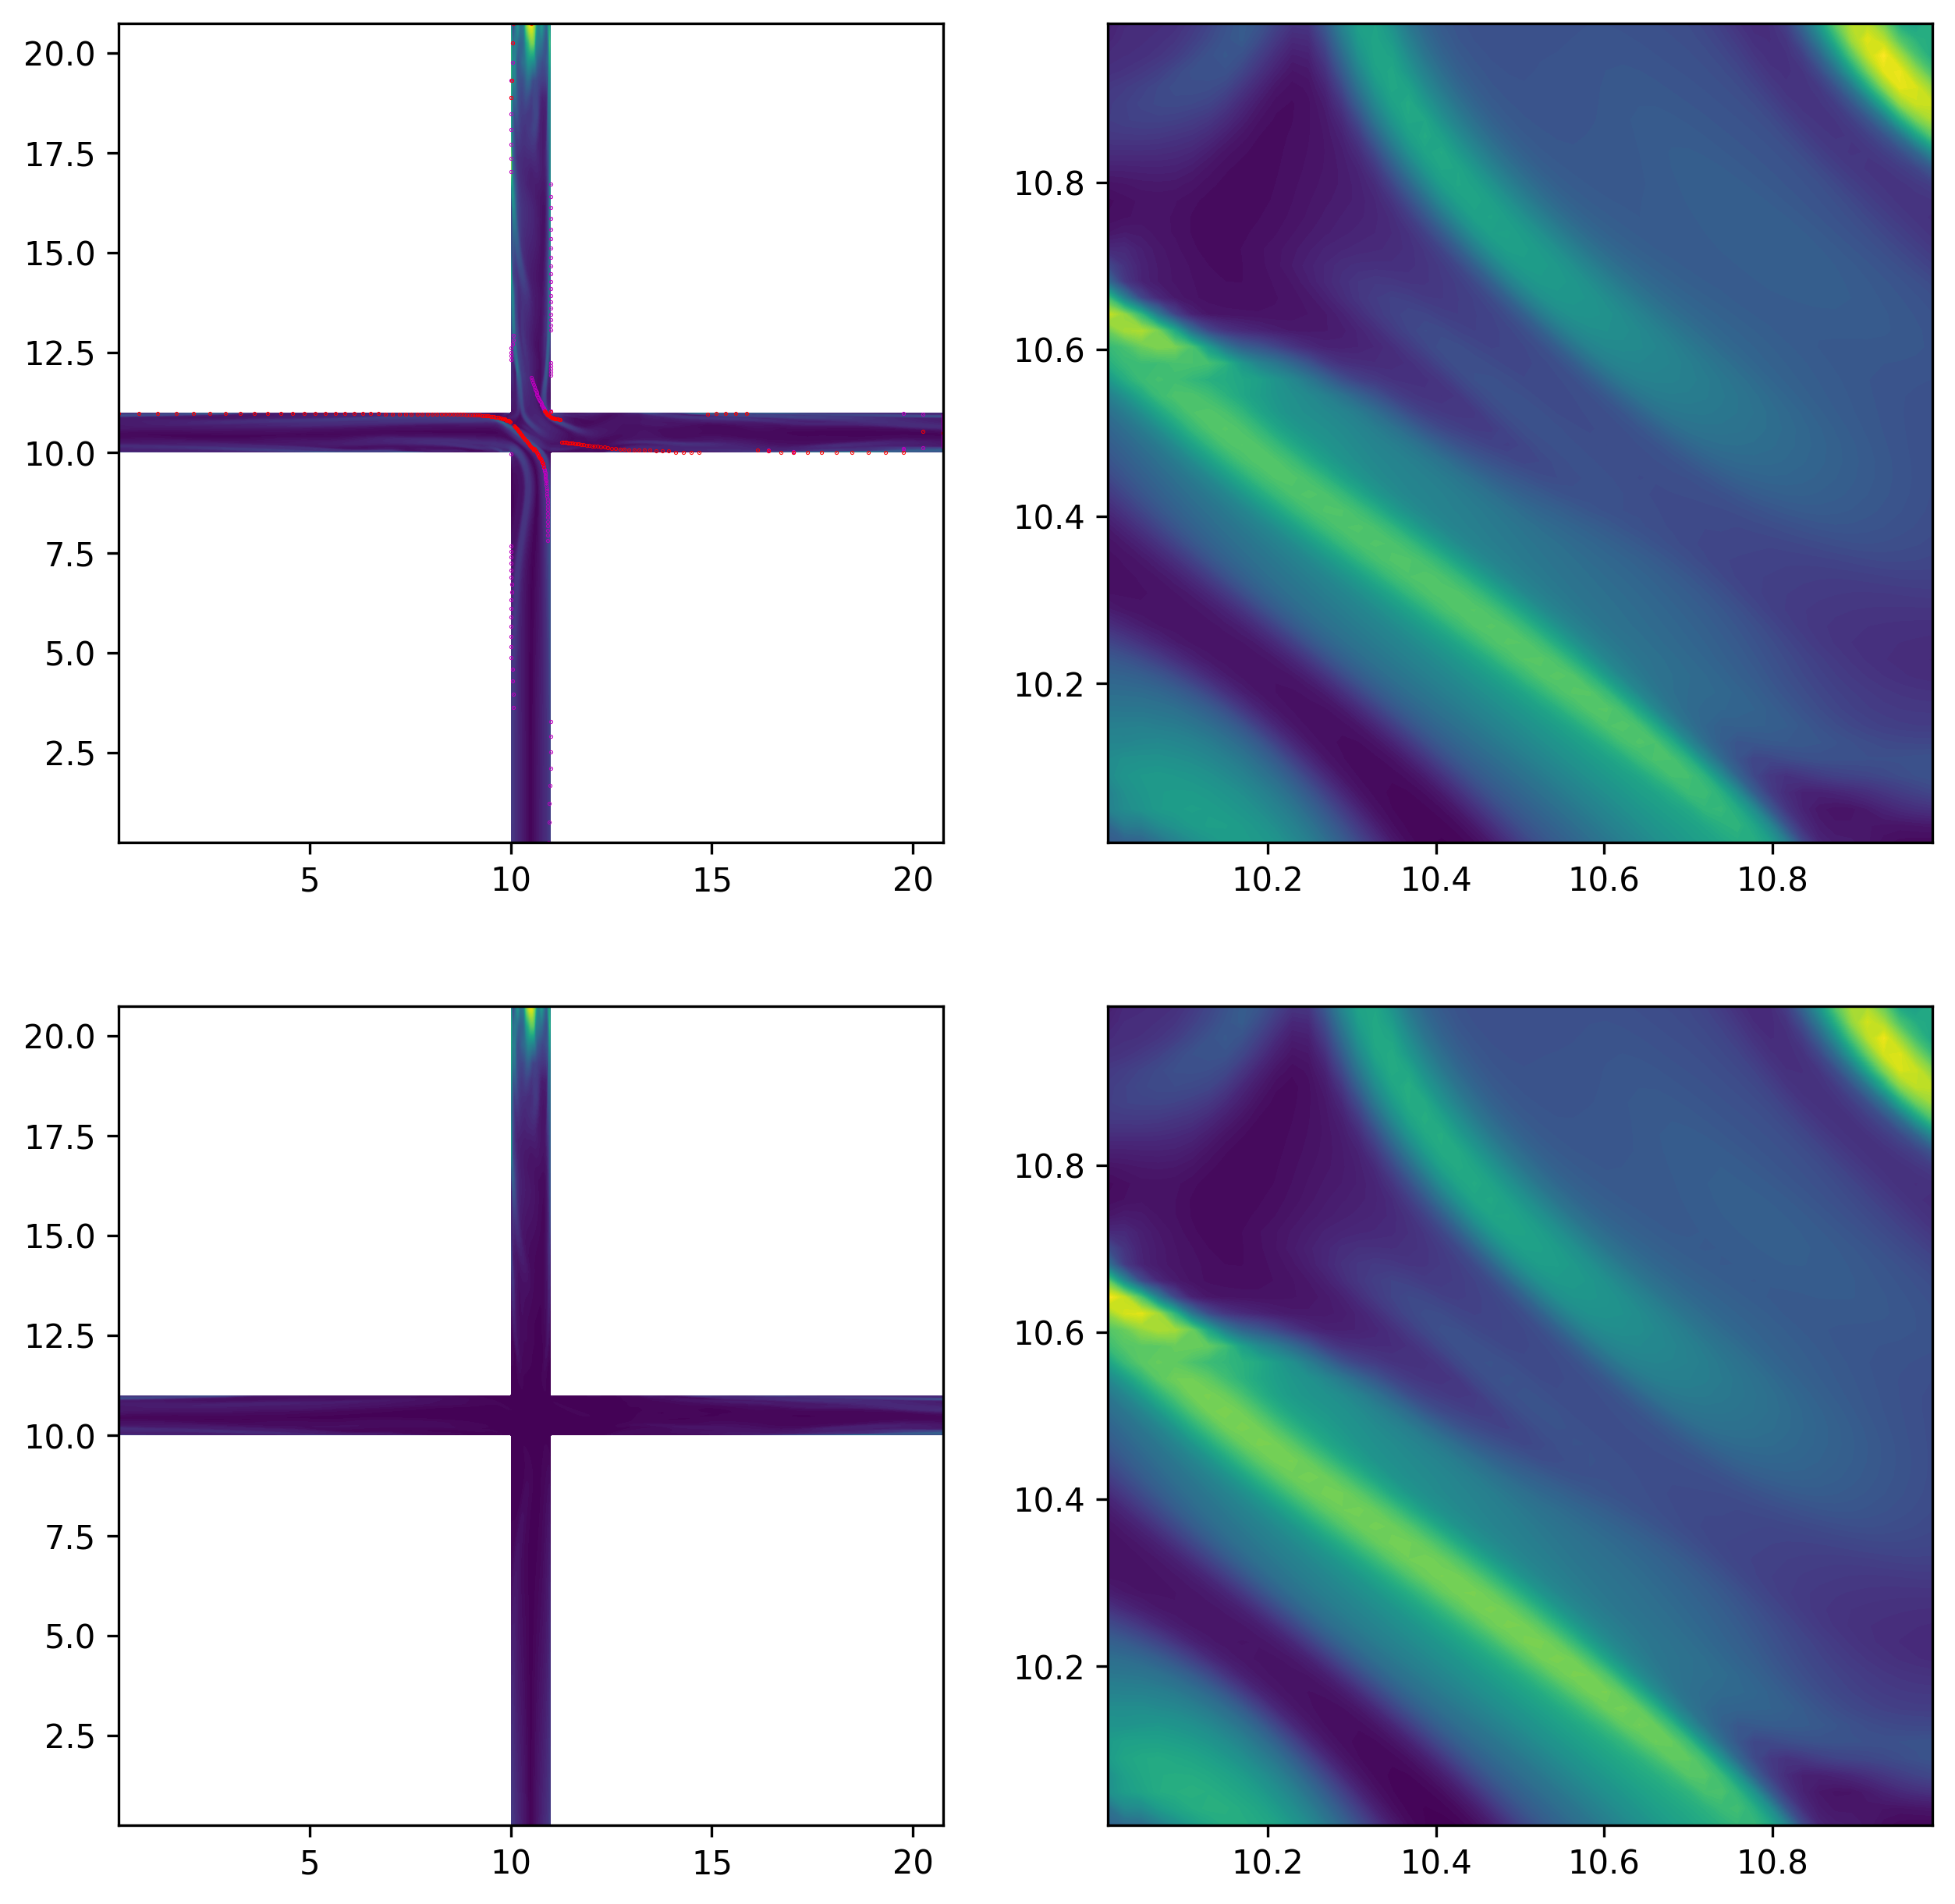

In [38]:
t = -1
fig =plt.figure(figsize=(10,10),dpi=300,facecolor='w')

ax1 = plt.subplot(221)
ax = plt.contourf(X,Y,(tra[...,t]), levels = 100)
vmax = np.nanargmax(tra[...,t])
xmax = np.nanargmax(tra[...,t], axis = 0)
ymax = np.nanargmax(tra[...,t], axis = 1)
plt.plot(X[range(181),xmax], Y[range(181),xmax], 'm.', markersize = .5)
plt.plot(X[ymax,range(181)], Y[ymax,range(181)], 'r.', markersize = .5)
plt.plot(X.item(vmax), Y.item(vmax), 'r.', markersize = .5)
# plt.colorbar()
# plt.colorbar()

ax1 = plt.subplot(222)
plt.contourf(X[65:-65,65:-65],Y[65:-65,65:-65],(tra[...,t]/AREA)[65:-65,65:-65], levels = 100)
# plt.colorbar()

ax1 = plt.subplot(223)
ax = plt.contourf(X,Y,(tra[...,t]*AREA), levels = 100)


ax1 = plt.subplot(224)
plt.contourf(X[65:-65,65:-65],Y[65:-65,65:-65],(tra[...,t]*AREA)[65:-65,65:-65], levels = 100)
# plt.colorbar()


In [ ]:
encoder  = Autoencoder.Encoder(4)
decoder  = Autoencoder.Decoder(4)

autoencoder = nn.Sequential(encoder, decoder)

In [ ]:
def get_reconst(Re,Wi,beta,eps, X, modes_list, kernel, loss_kernel, norm):

    E_mmq = []
    F_mmq = []
    E_energy = []
    degree = 1
    alpha = (1-beta)/(Re*Wi)
    _, _, total_X = calc_energy(X, Wi, beta, Re, dx = 0.0125)
    # target_X = (X-Xmean).T
    target_X = X.T
    
    max_m = np.max(modes_list)
    # _, Q, _, _ = kpca(X.T, n_components=max_m, kernel=kernel, gamma=alpha, norm=norm, eps = eps)# Old
    Q, _, _, _ = kpca(X.T, n_components=max_m, kernel=kernel, gamma=alpha, norm=norm, eps = eps) 
    for modes in modes_list:
        Qtest = Q[...,:modes]
        Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
        R, _, _, _ = np.linalg.lstsq(Q2, target_X, rcond=None)
        
        Xtilde = R.T@Q2.T
        # Xtilde += Xmean

        if loss_kernel == 'ptt' or loss_kernel == 'giesekus':
            E = loss_energy_iter(X,Xtilde,kernel_type = loss_kernel, theta=alpha, eps = eps, norm=True)
        else:
            E = loss_energy(X,Xtilde,kernel_type = loss_kernel, theta=alpha, eps = eps, norm=True)
        E_mmq.append(E)
        F_mmq.append(np.linalg.norm(X - Xtilde)/np.linalg.norm(X))

        _, _, total = calc_energy(Xtilde, Wi, beta, Re, dx = 0.0125)


        # err_energy = np.abs(total_X - total).sum() / np.abs(total_X).sum()
        err_energy = np.abs((total_X - total)/total_X).sum()
        E_energy.append(err_energy)
    return F_mmq, E_mmq, E_energy

In [ ]:
(.1)/(1e-4*4.5)

In [ ]:
Re = 5e-3
Wi = 1
beta = 0.5
alpha = (1-beta)/(Re*Wi)
print(alpha)
dx = 2*np.pi / 2**6
# dx = 1/181

# in_filename = f'../npz_data/new_cross_data_Re0.01_Wi5_beta0.11111.npz'
# in_filename = f'../npz_data/cross_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz'
in_filename = f'../npz_data/4_roll6_Re{Re:g}_Wi{Wi:g}_beta{beta:g}_dataset.npz'

eps_u = 1

fields = np.load(in_filename, allow_pickle=True)["fields"].item()
u = fields["vel-u"] * eps_u
v = fields["vel-v"] * eps_u
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]
q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)
# q[:65,:65] = 0
# q[:65,-65:] = 0
# q[-65:,:65] = 0
# q[-65:,-65:] = 0
# q = q[65:116,65:116]
TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2])) 
TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2])) 
T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0

Tmean = T.mean(1).reshape(-1,1)

# T  = T - Tmean

In [2]:
Re = .01
Wi = 5
beta = 0.11111

X, Xmean =  get_data(Re,Wi,beta, 'cross', n_data= -2, dir_path='../npz_data')

In [3]:
181*181*5, X.shape

(163805, (163805, 999))

In [50]:
np.sqrt(13005/5)

51.0

In [10]:
q = X.reshape((181,181,5,-1))

In [31]:
q[65:-65].shape

(51, 181, 5, 999)

In [33]:
51*181 + 3315

12546

(15861, 5, 999)


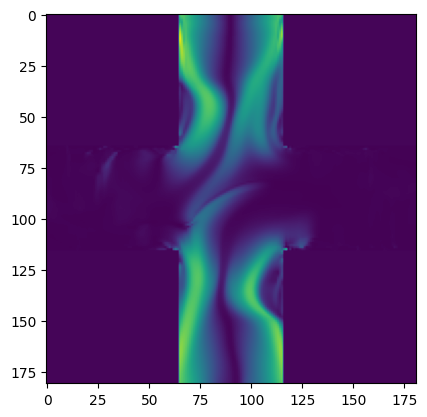

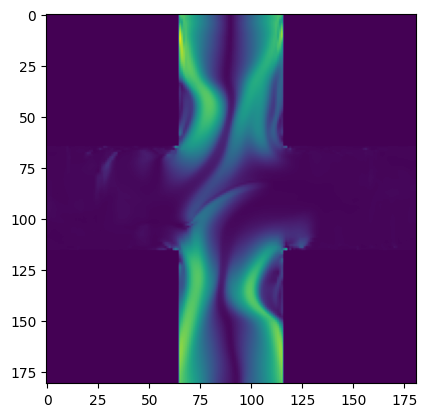

In [41]:
q1 = strip_cross(q)
print(q1.shape)
q2 = reconstruct_cross(q1)


plt.imshow(q[...,2,500])
plt.figure()
plt.imshow(q2[...,2,500])

In [ ]:
DX.shape, X.shape

In [6]:
import numpy as np
a = np.ones((2,2))
a@a
from utils import *
import Autoencoder
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import time
import os


In [8]:

torch.manual_seed(42) # reprodutibility
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

latent_dim = 2

In [81]:
## Cross-Slot Data

# Parameters:
Re = 0.01
Wi = 5
beta = 0.11111

# Mesh information:
vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X, Y = np.meshgrid(xc,yc)
DX, DY = np.meshgrid(dx,dy)
AREA = DX*DY
# type of simulation
case = 'cross'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')

Nt = X.shape[1] # number of snapshots
q = X.reshape((181,181,5,-1))
#Norm data by dx
area_norm = ''
if area_norm == 'MULT':
    q_norm = (q * AREA.reshape((181,181,1,1)))
elif area_norm == 'DIV':
    q_norm = (q / AREA.reshape((181,181,1,1)))

##### Non Norm
X_data = strip_cross(q)
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data)

#normalize data inside autoencoder
lower_bound = torch.from_numpy(X_data.min(axis = (0,2)).reshape((1,5,1))).float().to(device)
upper_bound = torch.from_numpy(X_data.max(axis = (0,2)).reshape((1,5,1))).float().to(device)
# X_torch = (X_torch - lower_bound)/(upper_bound - lower_bound)

########### Norm
X_data_norm = strip_cross(q_norm)
X_data_norm = np.moveaxis(X_data_norm,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch_norm = torch.from_numpy(X_data_norm)

#normalize data inside autoencoder
lower_bound_norm = torch.from_numpy(X_data_norm.min(axis = (0,2)).reshape((1,5,1))).float().to(device)
upper_bound_norm = torch.from_numpy(X_data_norm.max(axis = (0,2)).reshape((1,5,1))).float().to(device)
# X_torch = (X_torch - lower_bound)/(upper_bound - lower_bound)

autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)
autoencoder.load_state_dict(torch.load('../Models/Dense_Cross_Latent_2_MULT/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [82]:
autoencoder.load_state_dict(torch.load('../Models/Dense_Cross_Latent_2/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
## 4-roll data


## Data reading

# Parameters:
Re = 1
Wi = 5
beta = 0.1
# type of simulation
case = '4roll'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')

Nt = X.shape[1] # number of snapshots
X_data = X.reshape((-1,5,Nt))
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data)

#normalize data inside autoencoder
lower_bound = torch.from_numpy(X_data.min(axis = (0,2)).reshape((1,5,1))).float().to(device)
upper_bound = torch.from_numpy(X_data.max(axis = (0,2)).reshape((1,5,1))).float().to(device)
# X_torch = (X_torch - lower_bound)/(upper_bound - lower_bound)

# NN part
learning_rate = 1e-4
bs = 100
num_epochs = 5000

autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

In [26]:
a = {x:x**2 for x in range(3)}
a[2]

4

In [49]:
autoencoder = Autoencoder.AutoencoderModule(n_input= q1.shape[0], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

In [52]:
q1.shape[0], X_torch.shape[-1]

(15861, 4096)

In [ ]:
296 221 623

In [50]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(autoencoder))

296221623


In [8]:
param_size = 0
for param in autoencoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in autoencoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
size_param_mb = (param_size ) / 1024**2
size_buffer_mb = ( buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('param size: {:.3f}MB'.format(size_param_mb))
print('buffer size: {:.3f}MB'.format(size_buffer_mb))

model size: 0.216MB
param size: 0.215MB
buffer size: 0.002MB


In [2]:
import matplotlib.pyplot as plt

In [3]:
Xd = X.reshape((64,64,5,-1))
field = 3


In [39]:
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
Nt = X.shape[1] # number of snapshots
X_data = X.reshape((-1,5,Nt))
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data).float()

#normalize data
lower_bound = X_data.min(axis = (0,2)).reshape((1,5,1))
upper_bound = X_data.max(axis = (0,2)).reshape((1,5,1))
X_torch = (X_torch - lower_bound)/(upper_bound - lower_bound)
print(X_torch.shape)


torch.Size([3998, 5, 4096])


In [41]:
X_torch = X_torch.float()

In [35]:
dense = torch.nn.Linear(4096,10)

In [43]:
output = dense(X_torch)
print(output.shape)

torch.Size([3998, 5, 10])


In [21]:
Re = 1
Wi = 5
beta = 0.1
alpha = (1-beta)/(Re*Wi)
print(alpha)
dx = 2*np.pi / 2**6
# dx = 1/181

# in_filename = f'../npz_data/new_cross_data_Re0.01_Wi5_beta0.11111.npz'
# in_filename = f'../npz_data/cross_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz'
in_filename = f'../npz_data/4_roll6_Re{Re:g}_Wi{Wi:g}_beta{beta:g}_dataset.npz'

eps_u = 1

fields = np.load(in_filename, allow_pickle=True)["fields"].item()
u = fields["vel-u"] * eps_u
v = fields["vel-v"] * eps_u
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]
q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)
# q[:65,:65] = 0
# q[:65,-65:] = 0
# q[-65:,:65] = 0
# q[-65:,-65:] = 0
# q = q[65:116,65:116]
TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2])) 
TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2])) 
T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0

Tmean = T.mean(1).reshape(-1,1)

0.18


In [16]:
# case = '4roll'
# X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
# X.shape


case = 'cross'
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
X.shape

(163805, 999)

In [22]:
T.shape

(20480, 4000)

In [33]:
AREA.shape, np.tile(AREA,5,).shape, 181*181,181*181*5

((181, 181), (181, 905), 32761, 163805)

In [27]:
X = X_data.reshape((999,-1)).T
alpha = (1-beta)/(Re*Wi)
DXs = strip_cross(DX.reshape((181,181,1,1))).reshape((-1,))
DYs = strip_cross(DY.reshape((181,181,1,1))).reshape((-1,))
X.shape, DXs.shape

((79305, 999), (15861,))

In [28]:
degree = 1

ncomp =2
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T
# Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = DX.reshape((-1,1)).T, dy = DY.reshape((-1,1)).T) 
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = DXs.reshape((-1,1)).T, dy = DYs.reshape((-1,1)).T) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T


In [25]:
X

array([[0.0007703 , 0.00080367, 0.0008649 , ..., 0.00085912, 0.00085852,
        0.00085792],
       [0.00181161, 0.0018803 , 0.00200607, ..., 0.00199746, 0.00199589,
        0.00199429],
       [0.00295156, 0.00304677, 0.00322015, ..., 0.00320742, 0.00320449,
        0.00320152],
       ...,
       [0.00982077, 0.00965624, 0.00940352, ..., 0.00706465, 0.007069  ,
        0.00707446],
       [0.00980926, 0.00963062, 0.00935809, ..., 0.00686376, 0.00686594,
        0.00686888],
       [0.00980034, 0.00961078, 0.00932247, ..., 0.00682679, 0.00682747,
        0.00682849]])

In [29]:
# elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))
# elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))
# elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))


elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DXs.reshape((-1,1)), dy = DYs.reshape((-1,1)))
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = DXs.reshape((-1,1)), dy = DYs.reshape((-1,1)))
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = DXs.reshape((-1,1)), dy = DYs.reshape((-1,1)))

# elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = 1, dy = 1)
# elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = 1, dy = 1)
# elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = 1, dy = 1)


# elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx.T)
# elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx.T)
# elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx.T)

In [7]:

latent_dim = 2
Nt = X.shape[1]
X_data = X.reshape((-1,5,Nt))
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data)

#normalize data inside autoencoder
lower_bound = torch.from_numpy(X_data.min(axis = (0,2)).reshape((1,5,1))).float().to(device)
upper_bound = torch.from_numpy(X_data.max(axis = (0,2)).reshape((1,5,1))).float().to(device)
lower_bound_conv = torch.from_numpy(X_data.min(axis = (0,2)).reshape((1,5,1,1))).float().to(device)
upper_bound_conv = torch.from_numpy(X_data.max(axis = (0,2)).reshape((1,5,1,1))).float().to(device)
# X_torch = (X_torch - lower_bound)/(upper_bound - lower_bound)

autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load('../Models/Dense_Latent_2_merged/best_autoencoder',map_location=torch.device('cpu')))


conv = Autoencoder.ConvAutoencoderModule(latent_dim = latent_dim, max_in=upper_bound_conv, min_in=lower_bound_conv).to(device)

conv.load_state_dict(torch.load('../Models/Conv_Latent_2/best_conv_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
conv = Autoencoder.ConvAutoencoderModule(latent_dim = 8, max_in=upper_bound_conv, min_in=lower_bound_conv).to(device)

conv.load_state_dict(torch.load('../Models/Conv_Latent_8/best_conv_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [67]:
X_ae_t.shape, DXs.shape

((999, 5, 15861), (15861,))

In [63]:
a = np.ones((2,2,5))
a[...,1] *= 2
a[...,2] *= 3 
a[...,3] *= 4
a[...,4] *= 5

print(a.reshape(-1))

[1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5.]


In [76]:
autoencoder.min = lower_bound_norm
autoencoder.input_range = upper_bound_norm - lower_bound_norm

In [79]:
## Autoencoder

X_ae_t = autoencoder(X_torch_norm.float()).detach().numpy()
X_ae = X_ae_t / (DXs * DYs).reshape((1,1,-1)) # denormalize
# X_ae = X_ae_t # denormalize
X_ae = X_ae.reshape((999,-1)).T# Get correct shape
# q_ae = reconstruct_cross(X_ae)
# q_ae = (q_ae / AREA.reshape((181,181,1,1)))
# q_ae =np.moveaxis(q_ae,[2],[0]).reshape((-1,999))
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DXs.reshape((-1,1)), dy = DYs.reshape((-1,1)))
# elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = 1, dy = 1)

In [86]:
## Autoencoder

X_ae_t = autoencoder(X_torch.float()).detach().numpy()
# X_ae = X_ae_t / (DXs * DYs).reshape((1,1,-1)) # denormalize
X_ae = X_ae_t # 
X_ae = X_ae.reshape((999,-1)).T# Get correct shape
# q_ae = reconstruct_cross(X_ae)
# q_ae = (q_ae / AREA.reshape((181,181,1,1)))
# q_ae =np.moveaxis(q_ae,[2],[0]).reshape((-1,999))
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DXs.reshape((-1,1)), dy = DYs.reshape((-1,1)))
# elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = 1, dy = 1)

In [13]:
## Conv Autoencoder
X_cae_t = conv(X_torch.reshape((Nt,5,64,64)).float())

X_cae =X_cae_t.moveaxis([1],[-1]).reshape((Nt,-1)).detach().numpy().T
elastic_cae, kinetic_cae, total_cae = calc_energy(X_cae,Wi,beta,Re,dx = dx)

In [69]:
# Mesh information:
vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X, Y = np.meshgrid(xc,yc)
DX, DY = np.meshgrid(dx,dy)
AREA = DX*DY
# type of simulation
case = 'cross'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')

Nt = X.shape[1] # number of snapshots
q = X.reshape((181,181,5,-1))

AREA.shape, q.shape, X.shape

((181, 181), (181, 181, 5, 999), (163805, 999))

In [71]:
(AREA.reshape((181,181,1,1)) * q).shape

(181, 181, 5, 999)

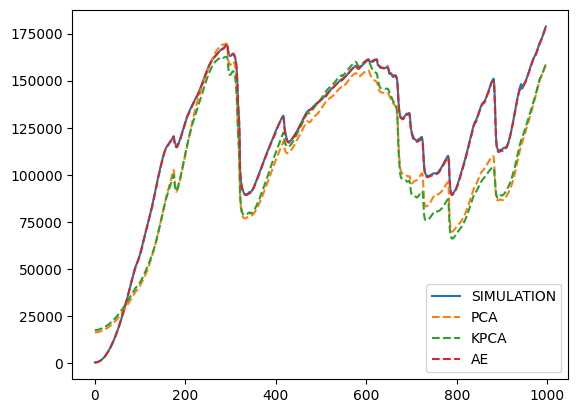

In [87]:
ini = 0
fim = -1
# plt.plot(total[0:fim], label = 'SIMULATION')
# plt.plot(total_linear[0:fim],'--', label = 'PCA')
# plt.plot(total_oldroyd[0:fim],'--', label = 'KPCA')
plt.plot(total[ini:fim], label = 'SIMULATION')
plt.plot(total_linear[ini:fim],'--', label = 'PCA')
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'AE')
# plt.plot(total_cae[ini:fim],'--', label = 'CAE')
plt.legend()

In [ ]:
total_100 = total

In [73]:
import torch.nn as nn

In [74]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)

c:\Users\fabio\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [99]:
transformer_model(src, False)

AttributeError: 'bool' object has no attribute 'size'

In [110]:
f'{.0002325:.06g}'

'0.0002325'

In [77]:
tgt[0,0,:10], out[0,0,:10]

(tensor([0.8136, 0.2267, 0.2835, 0.1767, 0.4720, 0.6251, 0.9429, 0.7862, 0.6980,
         0.1885]),
 tensor([ 0.6168, -2.6940,  0.8722,  0.1833, -0.2703, -1.9172,  0.9748,  2.1725,
          0.6758,  0.1868], grad_fn=<SliceBackward0>))

In [ ]:
# plt.plot(total_001)
plt.plot(total_1)
plt.plot(total_100)

In [ ]:
plt.plot(elastic)
plt.plot(elastic_linear,'--')
plt.plot(elastic_oldroyd,'--')

In [ ]:
plt.plot(kinetic)
plt.plot(kinetic_linear,'--')
plt.plot(kinetic_oldroyd,'--')

In [ ]:
modes_list = np.arange(1,11)
F_pca, H_pca, E_pca = get_reconst(Re,Wi,beta,None, X, modes_list, 'linear', 'oldroyd', 'DIV')
F_oldroyd, H_oldroyd, E_oldroyd = get_reconst(Re,Wi,beta,None, X, modes_list, 'oldroyd', 'oldroyd', 'DIV')

In [ ]:
plt.plot(modes_list,E_pca)
plt.plot(modes_list,E_oldroyd, '--')

In [31]:
X_ae = X_ae.detach().numpy()

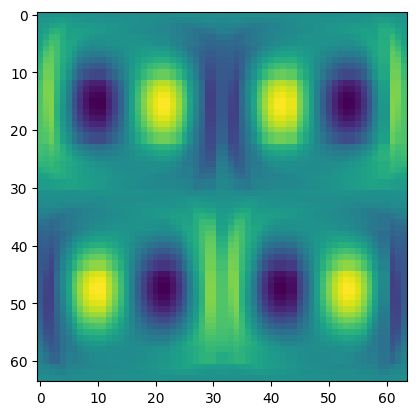

In [39]:
im = X_ae[...,50].reshape((64,64,5))
im = X[...,50].reshape((64,64,5))
plt.imshow(im[...,0])